#**선형 회귀 모델**


## * 선형 회귀 모델(Linear Regression Model)의 정의
종속 변수 Y를 독립 변수 X들의 선형 결합으로 표현한 모델이다.

$$ Y = \beta_0+\beta_1X_1+\beta_2X_2+\dots+\beta_pX_p $$

독립 변수 하나만으로 종속 변수를 예측하는 모델을 단순 선형 회귀 모델(Simple Linear Regression Model)이라고 한다.

$$ Y = \beta_0+\beta_1X_1 $$

회귀 모델 파악을 쉽게 하기 위해 단순 선형 회귀 모델을 구현해보면서 공부해보자.

## * 선형 회귀 가정
선형 회귀 모델에서 우리는 몇가지 가정을 하는데,
$$ Y_i=\beta_0+\beta_1X_i+\epsilon $$
에서, 오차항 $\epsilon$은 정규분포 $N(0,\sigma^2)$를 따르고, $E(\epsilon_i)=0, V(\epsilon_i)=\sigma^2$이라는 것이다.

여기서, 오차항 $\epsilon$은 $X$로는 설명되지 않는, 그래프에서는 회귀하는 직선에서 벗어나있는 정도라고 말할 수 있다.

## * 선형 회귀 추정
선형 회귀 모델에서 가중치를 추정하는 방법은, 오차제곱합 즉 $\sum_{i=1}^n[Y_i-(\beta_0+\beta_1X_i)]^2$의 결과가 가장 작아지게 하는 $\beta_0$, $\beta_1$를 찾아내는 것이다. 여기서, $\sum_{i=1}^n[Y_i-(\beta_0+\beta_1X_i)]^2$이 식을 비용함수(cost function) 또는 손실함수(loss function)라고 한다.

손실함수를 미분한 값의 기울기가 0일 떄, 손실함수의 최소값이 되는데, 복잡한 식을 통해 $\hat\beta_0$, $\hat\beta_1$을 도출해내면 다음과 같다.
$$\hat\beta_0=\bar Y-\hat\beta_0\bar X$$

$$\hat{\beta_1}=\frac{\sum_{i=1}^n(X_i-\bar{X})(Y_i-\bar{X})}{\sum_{i=1}^n(X_i-\bar{X})^2}$$

위와 같은 알고리즘을 최소제곱법이라고 한다.

#  **선형 회귀 모델 실습** 

## 라이브러리 불러오기

In [1]:
# 넘파이
import numpy as np
# 데이터 시각화를 위한 matplotlib
import matplotlib.pyplot as plt
# 파이토치를 불러온다.
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.init as init

## Hyper parameter 설정

In [2]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [3]:
config = Config({
    # Training parameters.
    # 데이터의 개수는 1000개, 학습 횟수 2000회, 학습률은 0.01로 설정
    'num_data' : 1000,
    'epochs': 2000,
    'learning_rate': 0.001
})

## 데이터 설정

In [4]:
# 데이터의 x값은 -50부터 50까지 균등분포를 따르게 설정
x = init.uniform_(torch.Tensor(config.num_data, 1), -50, 50)
# y값은 10x-17이라는 임의의 선형방정식을 따른다.
y = 10*x-17

# y_noise는 y값으로부터 noise만큼의 오차가 생기는데,
# noise는 표준편차가 20인 가우시안 분포를 따름
noise = init.normal_(torch.Tensor(config.num_data, 1), std=20)
y_noise = y+noise

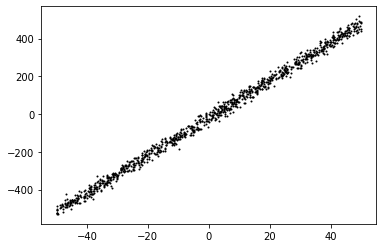

In [5]:
# 데이터 확인
# plt.figure(figsize=(10, 10))
plt.scatter(x.numpy(), y_noise.numpy(), s = 1, c='black')
# plt.axis([-60, 60, -620, 620])
plt.show()

## model 설정
단순 선형 회귀 모델이므로,
입력 차원과 출력 차원 모두 1이다.
$$ H(x)=Wx+b$$

In [6]:
model = nn.Linear(1, 1)

## loss function 설정
손실 함수는 평균 제곱 오차(MSE)를 사용했다.
$$cost(W, b)=\frac{1}{n}\sum_{i=1}^n[Y_i-\hat{Y}_i]^2$$

수식으로는 위와 같이 쓸 수 있고, $Y$가 원래의 값, $\hat{Y}$가 예측값이다. 즉, 각각의 오차의 제곱합의 평균을 구하는 함수를 손실함수로 잡는다.

In [7]:
loss_func = nn.MSELoss()

## Optimizer 설정
확률적 경사 하강법(SGD)을 사용했다.

다음 식은 경사 하강법(GD)이다.
$$ W\leftarrow W-\eta\frac{\partial L}{\partial W}$$

여기에서 $W$는 갱신할 가중치 매개변수, $\frac{\partial L}{\partial W}$는 $W$에 대한 손실 함수의 기울기이다. $\eta$는 학습률(learning rate)를 의미한다.

확률적 경사 하강법은, 스텝마다 데이터 전체에서 GD를 사용하면 매우 느리므로, 스텝마다 한 개의 데이터만 무작위로 선택하고 그에 대한 경사를 계산하는 방법이다.

In [8]:
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)

## 학습

In [9]:
loss_arr = []
# 학습 횟수만큼 반복
for i in range(config.epochs):
    # 입력값 x를 모델에 넣어 결과값을 얻는다.
    out = model(x)
    # 결과값과 목표값 y_noise의 차이를 아까 설정한 MSE를 이용해 구한다.
    loss = loss_func(out, y_noise)

    # 이전 학습의 기울기를 지워 최적화 함수 초기화
    # 기울기를 지우지 않으면 이전에 업데이트 때문에 학습이 잘 이루어지지 않음
    optimizer.zero_grad()
    # 손실함수의 기울기를 구한다.
    loss.backward()
    # w, b를 업데이트시킴
    optimizer.step()

    # loss_arr에 손실 추가
    loss_arr.append(loss.detach().numpy())

## 데이터 시각화
검은색이 데이터,

빨간색이 모델 예측값

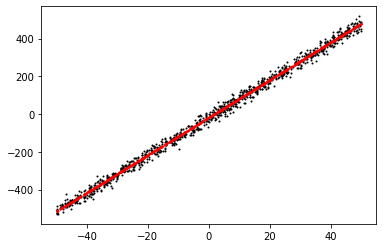

In [10]:
# plt.figure(figsize=(10, 10))
plt.scatter(x.numpy(), y_noise.numpy(), s = 1, c='black')
plt.scatter(x.detach().numpy(), out.detach().numpy(), s = 1, c='red')
# plt.axis([-60, 60, -620, 620])
plt.show()

## 손실 그래프

손실이 줄어가는 것을 볼 수 있다.

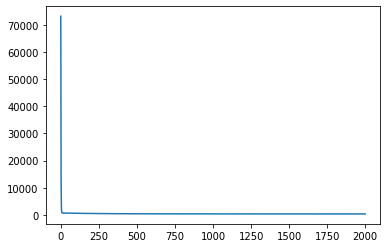

In [11]:
plt.plot(loss_arr)
plt.show()

## 학습 후 w와 b값 확인
실제 위에서 설정한 y = 10*x-17 에 w와 b가 근접한 것을 확인할 수 있다.

In [12]:
print("Weigtt : ", list(model.parameters())[0].item())
print("Bias :\t", list(model.parameters())[1].item())

Weigtt :  9.964728355407715
Bias :	 -17.85099983215332


### Reference
사이토 고키,『밑바닥부터 시작하는 딥러닝』, 개앞맵시 옮김, 한빛미디어(2019)

발렌티노 조카 외,『파이썬 라이브러리로 배우는 딥러닝 입문과 응용』, 이동근 옮김, 제이펍(2018)

이경택, 방성수, 안상준,『파이썬 딥러닝 파이토치』,정보문화사(2020)

김성범, [핵심 머신러닝] 선형회귀모델, https://www.youtube.com/watch?v=AZ45z0eGlaw&list=PLpIPLT0Pf7IoTxTCi2MEQ94MZnHaxrP0j&index=24
